Preparation

In [ ]:
!pip install --upgrade pip

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 45.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 63.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 11.4 MB/s eta 0:00:00


In [ ]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [ ]:
from __future__ import print_function
import pandas as pd
import matplotlib.pyplot as plt
import http.client
import json
import csv
import os
from textblob import TextBlob
import numpy as np
import time
import gc
import random
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate, train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from datetime import datetime, timedelta
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.utils import pad_sequences
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.datasets import imdb
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from textblob import TextBlob
#import shap
import spacy
import re
from dateutil import tz
from pytz import timezone
import pytz
from transformers import BertTokenizer, GPT2Tokenizer, TFGPT2Model, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures
#from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm import tqdm
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Load pre_categrized data for training models

In [ ]:
df_reddit = pd.read_csv('/content/drive/MyDrive/Reddit_Data.csv')
df_r = df_reddit.loc[(df_reddit['category'] == 1) | (df_reddit['category'] == -1)]
df_r.loc[df_r['category'] == -1,'category'] = 0
df_r.shape

Train BERT model

In [ ]:
bert = df_r.copy()
bert.columns = ['DATA_COLUMN', 'LABEL_COLUMN']
bert.head()

,DATA_COLUMN,LABEL_COLUMN
0,family mormon have never tried explain them t...,1
1,buddhism has very much lot compatible with chr...,1
2,seriously don say thing first all they won get...,0
4,for your own benefit you may want read living ...,1
5,you should all sit down together and watch the...,0


In [ ]:
bert.shape

(24107, 2)

In [ ]:
bert['DATA_COLUMN'] = bert['DATA_COLUMN'].astype(str)

In [ ]:
train_bert, test_bert = train_test_split(bert, test_size=0.3)

In [ ]:
train_bert.shape

(16874, 2)

In [ ]:
InputExample(guid=None,
             text_a = " ",
             text_b = None,
             label = 1)

InputExample(guid=None, text_a=' ', text_b=None, label=1)

In [ ]:
model_bert = TFBertForSequenceClassification.from_pretrained("bert-base-uncased")


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")


In [ ]:
model_bert.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109,483,778
Trainable params: 109,483,778
Non-trainable params: 0
_________________________________________________________________


In [ ]:
def convert_data_to_examples(train, test, DATA_COLUMN, LABEL_COLUMN): 
  train_InputExamples = train.apply(lambda x: InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                          text_a = x[DATA_COLUMN], 
                                                          text_b = None,
                                                          label = x[LABEL_COLUMN]), axis = 1)

  validation_InputExamples = test.apply(lambda x: InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                          text_a = x[DATA_COLUMN], 
                                                          text_b = None,
                                                          label = x[LABEL_COLUMN]), axis = 1)
  
  return train_InputExamples, validation_InputExamples

  train_InputExamples, validation_InputExamples = convert_data_to_examples(train, 
                                                                           test, 
                                                                           'DATA_COLUMN', 
                                                                           'LABEL_COLUMN')
  
def convert_examples_to_tf_dataset(examples, tokenizer, max_length=128):
    features = [] # -> will hold InputFeatures to be converted later

    for e in examples:
        # Documentation is really strong for this method, so please take a look at it
        input_dict = tokenizer.encode_plus(
            e.text_a,
            add_special_tokens=True,
            max_length=max_length, # truncates if len(s) > max_length
            return_token_type_ids=True,
            return_attention_mask=True,
            pad_to_max_length=True, # pads to the right by default # CHECK THIS for pad_to_max_length
            truncation=True
        )

        input_ids, token_type_ids, attention_mask = (input_dict["input_ids"],
            input_dict["token_type_ids"], input_dict['attention_mask'])

        features.append(
            InputFeatures(
                input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, label=e.label
            )
        )

    def gen():
        for f in features:
            yield (
                {
                    "input_ids": f.input_ids,
                    "attention_mask": f.attention_mask,
                    "token_type_ids": f.token_type_ids,
                },
                f.label,
            )

    return tf.data.Dataset.from_generator(
        gen,
        ({"input_ids": tf.int32, "attention_mask": tf.int32, "token_type_ids": tf.int32}, tf.int64),
        (
            {
                "input_ids": tf.TensorShape([None]),
                "attention_mask": tf.TensorShape([None]),
                "token_type_ids": tf.TensorShape([None]),
            },
            tf.TensorShape([]),
        ),
    )


DATA_COLUMN = 'DATA_COLUMN'
LABEL_COLUMN = 'LABEL_COLUMN'

In [ ]:
train_InputExamples, validation_InputExamples = convert_data_to_examples(train_bert, test_bert, DATA_COLUMN, LABEL_COLUMN)
train_data = convert_examples_to_tf_dataset(list(train_InputExamples), tokenizer)
#train_data = train_data.shuffle(100).batch(32).repeat(2)
train_data = train_data.shuffle(100).batch(32)

validation_data = convert_examples_to_tf_dataset(list(validation_InputExamples), tokenizer)
validation_data = validation_data.batch(32)

/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2346: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
train_InputExamples.shape

(16874,)

In [ ]:
train_InputExamples.head()

19755    InputExample(guid=None, text_a='aib extremely ...
20712    InputExample(guid=None, text_a='what fucking h...
15600    InputExample(guid=None, text_a='this indeed ho...
12381    InputExample(guid=None, text_a='hello thanks f...
35665    InputExample(guid=None, text_a=' was bright co...
dtype: object

In [ ]:
batch_size=32
early_stop = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=5)
policy = tf.keras.mixed_precision.Policy('mixed_float16')
tf.keras.mixed_precision.set_global_policy(policy)
tf.keras.callbacks.EarlyStopping

keras.callbacks.EarlyStopping

In [ ]:
model_bert.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0), 
              loss=tf.keras.losses.SparseCpy(ategoricalCrossentrofrom_logits=True), 
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')])

model_bert.fit(train_data, batch_size=batch_size, epochs=15, validation_data=validation_data, callbacks=[early_stop])

Epoch 1/15
528/528 [==============================] - 530s 912ms/step - loss: 0.3619 - accuracy: 0.8358 - val_loss: 0.2355 - val_accuracy: 0.9034
Epoch 2/15
528/528 [==============================] - 477s 903ms/step - loss: 0.1643 - accuracy: 0.9356 - val_loss: 0.2351 - val_accuracy: 0.9159
Epoch 3/15
528/528 [==============================] - 477s 903ms/step - loss: 0.0841 - accuracy: 0.9704 - val_loss: 0.2570 - val_accuracy: 0.9208
Epoch 4/15
528/528 [==============================] - 477s 903ms/step - loss: 0.0493 - accuracy: 0.9832 - val_loss: 0.2644 - val_accuracy: 0.9240
Epoch 5/15
528/528 [==============================] - 476s 901ms/step - loss: 0.0328 - accuracy: 0.9886 - val_loss: 0.3121 - val_accuracy: 0.9235
Epoch 6/15
528/528 [==============================] - 476s 902ms/step - loss: 0.0220 - accuracy: 0.9928 - val_loss: 0.3263 - val_accuracy: 0.9202
Epoch 7/15
528/528 [==============================] - 476s 902ms/step - loss: 0.0166 - accuracy: 0.9953 - val_loss: 0.3044 -

In [ ]:
score, acc = model_bert.evaluate(validation_data, batch_size=batch_size)

227/227 [==============================] - 64s 280ms/step - loss: 0.3064 - accuracy: 0.9229


In [ ]:
print('Test score:', score)
print('Test accuracy:', acc)

Test score: 0.3064226508140564
Test accuracy: 0.9228535890579224


In [ ]:
test_bert.head()

,DATA_COLUMN,LABEL_COLUMN
3983,hahahaha bedi you have only yourself blame,1
7805,been many states india and haryana relatively ...,1
24188,while yes this get votes this step much better...,1
26706,queste storie dei carabinieri polizia municipa...,0
24281,big true,1


In [ ]:
# Set batch size and initialize predictions array
batch_size = 32
all_predictions = np.empty((0,))

# Initialize tqdm with the total number of comments
progress_bar = tqdm(total=len(test_bert))

# Loop through the comments in batches
for i in range(0, len(test_bert), batch_size):
    # Get the batch of comments
    batch = test_bert['DATA_COLUMN'][i:i+batch_size].tolist()
    # Tokenize the batch
    tf_batch = tokenizer(batch, max_length=128, padding=True, truncation=True, return_tensors='tf')
    # Make predictions on the batch
    tf_outputs = model_bert(tf_batch)
    tf_predictions = tf.nn.softmax(tf_outputs[0], axis=-1)
    labels = tf.argmax(tf_predictions, axis=1).numpy()
    # Concatenate the predictions to the all_predictions array
    all_predictions = np.concatenate((all_predictions, labels))
    
    # Update the tqdm progress bar with the number of comments processed in this batch
    progress_bar.update(len(batch))

# Close the tqdm progress bar
progress_bar.close()

# Add the predictions array as a last column to the comment1 dataframe
test_bert['predictions_bert'] = all_predictions.astype(int)

100%|██████████| 7233/7233 [01:07<00:00, 107.55it/s]


In [ ]:
test_bert.head()

,DATA_COLUMN,LABEL_COLUMN,predictions_bert
3983,hahahaha bedi you have only yourself blame,1,1
7805,been many states india and haryana relatively ...,1,1
24188,while yes this get votes this step much better...,1,1
26706,queste storie dei carabinieri polizia municipa...,0,0
24281,big true,1,1


In [ ]:
true_labels = np.array(test_bert['LABEL_COLUMN'])
predicted_labels = np.array(test_bert['predictions_bert'])
#predicted_labels = np.argmax(np.array(test_bert['predictions_bert']), axis=1)
cm = confusion_matrix(true_labels, predicted_labels)

In [ ]:
def predict_tweet_sentiment(score):
    return (score > 0.5).astype("int32")
scores = model.predict(X_val)
model_predictions = [predict_tweet_sentiment(score) for score in scores]

In [ ]:
print(classification_report(true_labels, predicted_labels))

              precision    recall  f1-score   support

           0       0.91      0.86      0.89      2494
           1       0.93      0.96      0.94      4739

    accuracy                           0.92      7233
   macro avg       0.92      0.91      0.91      7233
weighted avg       0.92      0.92      0.92      7233



Text(51.0, 0.5, 'Predicted label')

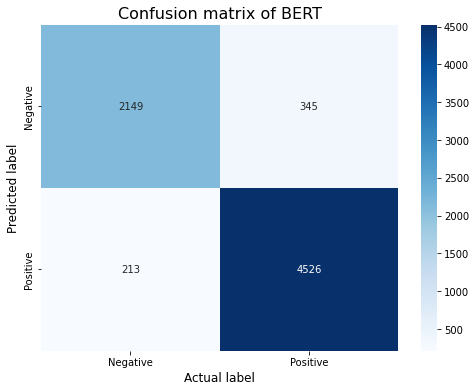

In [ ]:
# plot confusion matrix
sentiment_classes = ['Negative', 'Positive']
plt.figure(figsize=(8,6))
sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d',
            xticklabels=sentiment_classes,
            yticklabels=sentiment_classes)
plt.title('Confusion matrix of BERT', fontsize=16)
plt.xlabel('Actual label', fontsize=12)
plt.ylabel('Predicted label', fontsize=12)

In [ ]:
df_1 = test_bert.copy()
df_1['correct'] = df_1.apply(lambda x: 1 if x['LABEL_COLUMN'] == x['predictions_bert'] else 0, axis=1)


In [ ]:
df_1.shape

(7233, 4)

In [ ]:
df_fault = df_1[df_1['correct']==0]

In [ ]:
df_fault.shape

(618, 4)

In [ ]:
max_features = 3000
maxlen = 128  # cut texts after this number of words (among top max_features most common words)
batch_size = 32
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(df_fault['DATA_COLUMN'].values)

In [ ]:
word_counts_fault = tokenizer.word_counts
type(word_counts_fault)

collections.OrderedDict

In [ ]:
df_t = pd.DataFrame(word_counts_fault, index=[0])

In [ ]:
df_t1 = df_t.T
df_t1.to_csv('/content/drive/MyDrive/fault.csv', index=True)

In [ ]:
df_t1.shape

(8937, 1)

In [ ]:
max_features = 3000
maxlen = 128  # cut texts after this number of words (among top max_features most common words)
batch_size = 32
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(test_bert['DATA_COLUMN'].values)

In [ ]:
word_counts_all = tokenizer.word_counts
df_ta = pd.DataFrame(word_counts_all, index=[0])

In [ ]:
df_t2 = df_ta.T
df_t2.to_csv('/content/drive/MyDrive/all.csv', index=True)

Load downloaded 2021 and 2022 Reddit comments related with labour and work, predict with trained BERT model

In [ ]:
comment_work1 = pd.read_json("/content/drive/MyDrive/comments2021_work.txt")
comment_work2 = pd.read_json("/content/drive/MyDrive/comments2022_work.txt")
comment_labour1 = pd.read_json("/content/drive/MyDrive/comments2021_labor.txt")
comment_labour2 = pd.read_json("/content/drive/MyDrive/comments2022_labor.txt")
frames = [comment_work1, comment_work2, comment_labour1, comment_labour2]
comment = pd.concat(frames)
comment.shape

(173867, 11)

In [ ]:
comment['created_utc'] = pd.to_datetime(comment['created_utc'])
comment["post_id"] = comment["link_id"].str.split("_").str[-1]
comment['body'] = comment['body'].astype(str)
comment.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 173867 entries, 0 to 32945
Data columns (total 12 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   created_utc            173867 non-null  datetime64[ns]
 1   commentID              173867 non-null  object        
 2   link                   173867 non-null  object        
 3   is_submitter           173867 non-null  object        
 4   author                 173867 non-null  object        
 5   author_flair_richtext  173867 non-null  object        
 6   link_id                173867 non-null  object        
 7   parent_id              173867 non-null  object        
 8   score                  173867 non-null  int64         
 9   body                   173867 non-null  object        
 10  is_submitier           173867 non-null  object        
 11  post_id                173867 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(10)
me

In [ ]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
# Set batch size and initialize predictions array
batch_size = 32
all_predictions = np.empty((0,))

# Initialize tqdm with the total number of comments
progress_bar = tqdm(total=len(comment))

# Loop through the comments in batches
for i in range(0, len(comment), batch_size):
    # Get the batch of comments
    batch = comment['body'][i:i+batch_size].tolist()
    # Tokenize the batch
    tf_batch = tokenizer(batch, max_length=128, padding=True, truncation=True, return_tensors='tf')
    # Make predictions on the batch
    tf_outputs = model_bert(tf_batch)
    tf_predictions = tf.nn.softmax(tf_outputs[0], axis=-1)
    labels = tf.argmax(tf_predictions, axis=1).numpy()
    # Concatenate the predictions to the all_predictions array
    all_predictions = np.concatenate((all_predictions, labels))
    
    # Update the tqdm progress bar with the number of comments processed in this batch
    progress_bar.update(len(batch))

# Close the tqdm progress bar
progress_bar.close()

# Add the predictions array as a last column to the comment1 dataframe
comment['predictions_bert'] = all_predictions.astype(int)

100%|██████████| 173867/173867 [21:02<00:00, 137.75it/s]


In [ ]:
comment.to_csv('/content/drive/MyDrive/comment_bert.csv', index=False)

In [ ]:
comment.head()

NameError: ignored

In [ ]:
comment.shape

NameError: ignored

Load cleaned data to train LSTM model

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/df.csv')

In [ ]:
df.head()

,clean_comment,category
0,family mormon try explain stare puzzled time...,1
1,buddhism lot compatible christianity especiall...,1
2,seriously don thing win complex explain normal...,0
3,benefit want read live buddha live christ thic...,1
4,sit watch simpson episode lisa buddhist simpso...,0


In [ ]:
df.shape

(24107, 2)

In [ ]:
df['clean_comment'] = df['clean_comment'].astype(str)

In [ ]:
max_features = 3000
maxlen = 80  # cut texts after this number of words (among top max_features most common words)
batch_size = 32
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(df['clean_comment'].values)

In [ ]:
#tokenizer.word_counts
#tokenizer.word_index

In [ ]:
df_train, df_val = train_test_split(df, test_size=0.3)

In [ ]:
X_train = tokenizer.texts_to_sequences(df_train['clean_comment'].values)
X_train = pad_sequences(X_train,maxlen)
X_val = tokenizer.texts_to_sequences(df_val['clean_comment'].values)
X_val = pad_sequences(X_val,maxlen)

In [ ]:
Y_train = df_train['category'].values
Y_val = df_val['category'].values

In [ ]:
X_train

array([[   0,    0,    0, ..., 1850, 1209, 1638],
       [   0,    0,    0, ...,  130, 2218,   10],
       [   0,    0,    0, ...,    0,  552,  815],
       ...,
       [   0,    0,    0, ...,  213,   95,   75],
       [   0,    0,    0, ...,  198,   31,  908],
       [   0,    0,    0, ...,    0,   42, 1170]], dtype=int32)

In [ ]:
[X_train.shape,X_val.shape]

[(16874, 80), (7233, 80)]

In [ ]:
model_lstm = Sequential()
model_lstm.add(Embedding(max_features, 128))
model_lstm.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model_lstm.add(Dense(1, activation='sigmoid'))
early_stop = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=5)
policy = tf.keras.mixed_precision.Policy('mixed_float16')
tf.keras.mixed_precision.set_global_policy(policy)
tf.keras.callbacks.EarlyStopping

keras.callbacks.EarlyStopping

In [ ]:
model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
print('Train...')
model_lstm.fit(X_train, Y_train, batch_size=batch_size, epochs=15, validation_data=(X_val, Y_val), callbacks=[early_stop])

Train...
Epoch 1/15
528/528 [==============================] - 184s 342ms/step - loss: 0.4986 - accuracy: 0.7597 - val_loss: 0.4145 - val_accuracy: 0.8157
Epoch 2/15
528/528 [==============================] - 158s 299ms/step - loss: 0.3471 - accuracy: 0.8521 - val_loss: 0.4131 - val_accuracy: 0.8175
Epoch 3/15
528/528 [==============================] - 153s 290ms/step - loss: 0.2967 - accuracy: 0.8787 - val_loss: 0.4354 - val_accuracy: 0.8204
Epoch 4/15
528/528 [==============================] - 154s 292ms/step - loss: 0.2544 - accuracy: 0.8993 - val_loss: 0.4079 - val_accuracy: 0.8241
Epoch 5/15
528/528 [==============================] - 152s 288ms/step - loss: 0.2132 - accuracy: 0.9164 - val_loss: 0.4595 - val_accuracy: 0.8163
Epoch 6/15
528/528 [==============================] - 153s 290ms/step - loss: 0.1823 - accuracy: 0.9283 - val_loss: 0.5353 - val_accuracy: 0.8122
Epoch 7/15
528/528 [==============================] - 153s 290ms/step - loss: 0.1446 - accuracy: 0.9418 - val_loss:

In [ ]:
score_lstm, acc_lstm = model_lstm.evaluate(X_val, Y_val,
                            batch_size=batch_size)

227/227 [==============================] - 6s 26ms/step - loss: 0.7736 - accuracy: 0.8040


In [ ]:
print('Test score:', score_lstm)
print('Test accuracy:', acc_lstm)

Test score: 0.7735534310340881
Test accuracy: 0.8039541244506836


In [ ]:
predict = model_lstm.predict(X_val)

227/227 [==============================] - 6s 25ms/step


In [ ]:
Ynew = (predict > 0.5).astype("int32")

In [ ]:
df_val['predict'] = Ynew

In [ ]:
df_val.head()

,clean_comment,category,predict
6169,heartbreake picture hillary group child hold a...,1,1
18156,tax rebate upto lakh,1,0
22365,party want alliance congress deal work kejriwa...,1,1
5777,state bird punjab northern goshawk state rapto...,1,1
21422,venezuela nationalise private sector company o...,1,1


In [ ]:
true_labels = np.array(df_val['category'])
predicted_labels = np.array(df_val['predict'])
cm = confusion_matrix(true_labels, predicted_labels)
print(classification_report(true_labels, predicted_labels))

              precision    recall  f1-score   support

           0       0.72      0.70      0.71      2466
           1       0.85      0.86      0.85      4767

    accuracy                           0.80      7233
   macro avg       0.78      0.78      0.78      7233
weighted avg       0.80      0.80      0.80      7233



Text(51.0, 0.5, 'Predicted label')

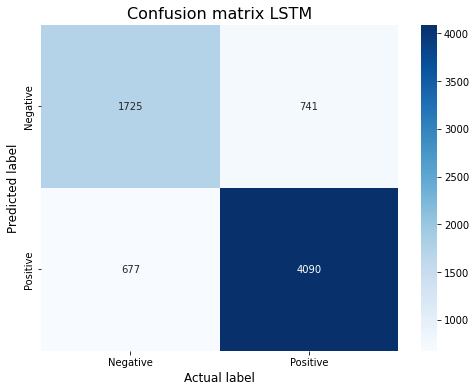

In [ ]:
# plot confusion matrix
sentiment_classes = ['Negative', 'Positive']
plt.figure(figsize=(8,6))
sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d',
            xticklabels=sentiment_classes,
            yticklabels=sentiment_classes)
plt.title('Confusion matrix LSTM', fontsize=16)
plt.xlabel('Actual label', fontsize=12)
plt.ylabel('Predicted label', fontsize=12)

In [ ]:
df_val['correct'] = df_val.apply(lambda x: 1 if x['category'] == x['predict'] else 0, axis=1)

In [ ]:
acc_lstm = df_val['correct'].sum()/df_val['correct'].count()
print(acc_lstm)

0.8027098022950366


In [ ]:
df_fault = df_val[df_val['correct']==0]

In [ ]:
df_fault.head()

,clean_comment,category,predict,correct
14235,come,0,1,0
7771,year year year year year year year year year...,0,1,0
8833,today rally organize goregaon mumbai bjp vhp a...,0,1,0
21556,fuck popular fuck major policy decision sort...,1,0,0
21312,man link look remind goro akechi persona leve...,1,0,0


In [ ]:
df_fault.shape

(1427, 4)

In [ ]:
max_features = 3000
maxlen = 80  # cut texts after this number of words (among top max_features most common words)
batch_size = 32
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(df_fault['clean_comment'].values)

In [ ]:

"""
word_counts = tokenizer.word_counts
print(word_counts)
#tokenizer.word_index
"""

'\nword_counts = tokenizer.word_counts\nprint(word_counts)\n#tokenizer.word_index\n'

Predict with textblob and Vader metholds

In [ ]:
df_train1, df_val1 = train_test_split(df, test_size=0.3)

In [ ]:
df_val1.head()

,clean_comment,category
15373,wrong vote retard lmao,0
9967,wait gdp come exact headline apart slowdown su...,1
8832,hope build damn temple asshole live jerk for...,1
7632,good point long time,1
9293,religion fine dandy rule not fucking kill peop...,0


In [ ]:
def get_sentiment_score(text):
    try:
        sid = SentimentIntensityAnalyzer()
        #print(f'SID object: {sid}')
        #print(f'Text input: {text}')
        #print(f'Sentiment scores: {sid.polarity_scores(str(text))}')
        return sid.polarity_scores(str(text))['compound']
    except Exception as e:
        #print(f'Error: {e}')
        return 0.0

In [ ]:
df_val1['polarity'] = df_val1['clean_comment'].apply(lambda x: TextBlob(str(x)).sentiment[0])
df_val1['polarity_v'] = df_val1['clean_comment'].apply(get_sentiment_score)
df_val1['sentiment'] = df_val1['polarity'].apply(lambda x: 1 if x>=0 else 0)
df_val1['sentiment_v'] = df_val1['polarity_v'].apply(lambda x: 1 if x>=0 else 0)
df_val1['textblob'] = df_val1.apply(lambda x: 1 if x['category'] == x['sentiment'] else 0, axis=1)
df_val1['vader'] = df_val1.apply(lambda x: 1 if x['category'] == x['sentiment_v'] else 0, axis=1)


In [ ]:
acc_textblob = df_val1['textblob'].sum()/df_val1['textblob'].count()
print(acc_textblob)
acc_vader = df_val1['vader'].sum()/df_val1['vader'].count()
print(acc_vader)

0.8722521775197014
0.7310935987833541


In [ ]:
df_val1.head()

,clean_comment,category,polarity,polarity_v,sentiment,sentiment_v,textblob,vader
15373,wrong vote retard lmao,0,-0.266667,-0.3818,0,0,1,1
9967,wait gdp come exact headline apart slowdown su...,1,0.035714,0.5994,1,1,1,1
8832,hope build damn temple asshole live jerk for...,1,0.136364,0.3182,1,1,1,1
7632,good point long time,1,0.325000,0.4404,1,1,1,1
9293,religion fine dandy rule not fucking kill peop...,0,0.358333,0.6961,1,1,0,0


In [ ]:
true_labels = np.array(df_val1['category'])
predicted_labels = np.array(df_val1['sentiment'])
cm = confusion_matrix(true_labels, predicted_labels)
print(classification_report(true_labels, predicted_labels))

              precision    recall  f1-score   support

           0       0.81      0.82      0.81      2465
           1       0.91      0.90      0.90      4768

    accuracy                           0.87      7233
   macro avg       0.86      0.86      0.86      7233
weighted avg       0.87      0.87      0.87      7233



Text(51.0, 0.5, 'Predicted label')

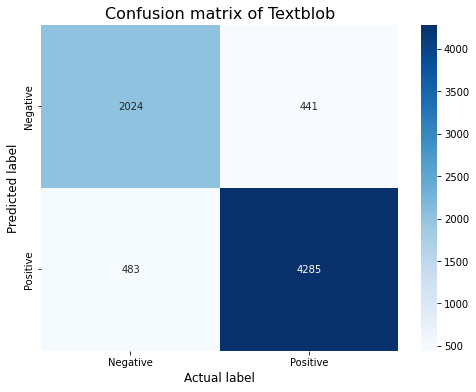

In [ ]:
# plot confusion matrix
sentiment_classes = ['Negative', 'Positive']
plt.figure(figsize=(8,6))
sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d',
            xticklabels=sentiment_classes,
            yticklabels=sentiment_classes)
plt.title('Confusion matrix of Textblob', fontsize=16)
plt.xlabel('Actual label', fontsize=12)
plt.ylabel('Predicted label', fontsize=12)

In [ ]:
true_labels = np.array(df_val1['category'])
predicted_labels = np.array(df_val1['sentiment_v'])
cm = confusion_matrix(true_labels, predicted_labels)
print(classification_report(true_labels, predicted_labels))

              precision    recall  f1-score   support

           0       0.60      0.65      0.62      2465
           1       0.81      0.77      0.79      4768

    accuracy                           0.73      7233
   macro avg       0.70      0.71      0.71      7233
weighted avg       0.74      0.73      0.73      7233



Text(51.0, 0.5, 'Predicted label')

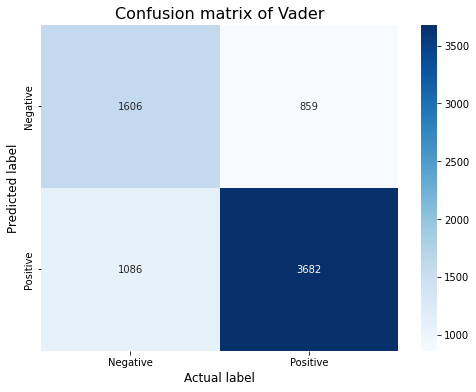

In [ ]:
# plot confusion matrix
sentiment_classes = ['Negative', 'Positive']
plt.figure(figsize=(8,6))
sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d',
            xticklabels=sentiment_classes,
            yticklabels=sentiment_classes)
plt.title('Confusion matrix of Vader', fontsize=16)
plt.xlabel('Actual label', fontsize=12)
plt.ylabel('Predicted label', fontsize=12)

In [ ]:
nlp = spacy.load('en_core_web_sm')

In [ ]:
comment = pd.read_csv('/content/drive/MyDrive/comment_bert.csv')

In [ ]:
comment.head()

,created_utc,commentID,link,is_submitter,author,author_flair_richtext,link_id,parent_id,score,body,is_submitier,post_id,predictions_bert
0,2021-12-31,hqrvdz6,https://www.reddit.com/r/work/comments/rsrfa3/...,NaN,Additional_Repeat_12,[],t3_rsrfa3,None,2,Even when I work salary I don’t answer calls d...,False,rsrfa3,1
1,2021-12-31,hqrupnz,https://www.reddit.com/r/work/comments/rtaumo/...,NaN,X-Bones_21,[],t3_rtaumo,38623883497,3,I second this. When I sorted for UPS I rarely...,False,rtaumo,1
2,2021-12-31,hqrtx88,https://www.reddit.com/r/work/comments/rtaumo/...,NaN,getfuckedhoayoucunts,[],t3_rtaumo,None,-3,CEO \n\nUsless fucks just sit piss arsing abou...,False,rtaumo,0
3,2021-12-31,hqrs9pw,https://www.reddit.com/r/work/comments/rtaumo/...,NaN,[deleted],NaN,t3_rtaumo,None,1,Accounting,False,rtaumo,1
4,2021-12-31,hqrrz2c,https://www.reddit.com/r/work/comments/rsp1vx/...,NaN,PristineAd9800,[],t3_rsp1vx,None,2,I’d work and see what happens. He didn’t cuz y...,False,rsp1vx,0


In [ ]:
comment.shape

(173867, 18)

In [ ]:
#Data cleaning;
comment['body1'] = comment['body'].astype(str)
comment['body1'] = comment['body1'].apply(lambda x: " ".join([y.lemma_ for y in nlp(x) if not y.is_stop]))
comment['body1'] = comment['body1'].apply(lambda x: x.lower())
comment['body1'] = comment['body1'].apply((lambda x: re.sub('[^\w\s]','',x)))

In [ ]:
comment.to_csv('/content/drive/MyDrive/comment_bert_cleaned.csv', index=False)

In [ ]:
max_features = 3000
maxlen = 80  # cut texts after this number of words (among top max_features most common words)
batch_size = 32
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(comment['body1'].values)

In [ ]:
X_val = tokenizer.texts_to_sequences(comment['body1'].values)
X_val = pad_sequences(X_val,maxlen)

In [ ]:
X_val.shape

(173867, 80)

In [ ]:
predict = model_lstm.predict(X_val)

5434/5434 [==============================] - 129s 24ms/step


In [ ]:
Ynew = (predict > 0.5).astype("int32")

In [ ]:
comment['predictions_lstm'] = Ynew

In [ ]:
comment['polarity'] = comment['body1'].apply(lambda x: TextBlob(str(x)).sentiment[0])
comment['polarity_v'] = comment['body1'].apply(get_sentiment_score)
comment['predictions_textblob'] = comment['polarity'].apply(lambda x: 1 if x>=0 else 0)
comment['predictions_vader'] = comment['polarity_v'].apply(lambda x: 1 if x>=0 else 0)



In [ ]:
comment.to_csv('/content/drive/MyDrive/comment_b_t_v_cleaned.csv', index=False)

In [ ]:
comment.head()

,created_utc,commentID,link,is_submitter,author,author_flair_richtext,link_id,parent_id,score,body,is_submitier,post_id,predictions_bert,predictions_textblob,predictions_vader,predictions_lstm
0,2021-12-31,hqrvdz6,https://www.reddit.com/r/work/comments/rsrfa3/...,NaN,Additional_Repeat_12,[],t3_rsrfa3,None,2,Even when I work salary I don’t answer calls d...,False,rsrfa3,1,1,1,1
1,2021-12-31,hqrupnz,https://www.reddit.com/r/work/comments/rtaumo/...,NaN,X-Bones_21,[],t3_rtaumo,38623883497,3,I second this. When I sorted for UPS I rarely...,False,rtaumo,1,1,0,0
2,2021-12-31,hqrtx88,https://www.reddit.com/r/work/comments/rtaumo/...,NaN,getfuckedhoayoucunts,[],t3_rtaumo,None,-3,CEO \n\nUsless fucks just sit piss arsing abou...,False,rtaumo,0,0,0,1
3,2021-12-31,hqrs9pw,https://www.reddit.com/r/work/comments/rtaumo/...,NaN,[deleted],NaN,t3_rtaumo,None,1,Accounting,False,rtaumo,1,1,1,1
4,2021-12-31,hqrrz2c,https://www.reddit.com/r/work/comments/rsp1vx/...,NaN,PristineAd9800,[],t3_rsp1vx,None,2,I’d work and see what happens. He didn’t cuz y...,False,rsp1vx,0,1,1,1


In [ ]:
comment.shape

(173867, 16)

In [ ]:
comment = comment.drop(['body1', 'polarity', 'polarity_v'], axis=1)

In [ ]:
comment.to_csv('/content/drive/MyDrive/comment_all_model.csv', index=False)

In [ ]:
comment = pd.read_csv('/content/drive/MyDrive/comment_all_model.csv')


In [ ]:
comment.head()

,created_utc,commentID,link,is_submitter,author,author_flair_richtext,link_id,parent_id,score,body,is_submitier,post_id,predictions_bert,predictions_textblob,predictions_vader,predictions_lstm
0,2021-12-31,hqrvdz6,https://www.reddit.com/r/work/comments/rsrfa3/...,NaN,Additional_Repeat_12,[],t3_rsrfa3,None,2,Even when I work salary I don’t answer calls d...,False,rsrfa3,1,1,1,1
1,2021-12-31,hqrupnz,https://www.reddit.com/r/work/comments/rtaumo/...,NaN,X-Bones_21,[],t3_rtaumo,38623883497,3,I second this. When I sorted for UPS I rarely...,False,rtaumo,1,1,0,0
2,2021-12-31,hqrtx88,https://www.reddit.com/r/work/comments/rtaumo/...,NaN,getfuckedhoayoucunts,[],t3_rtaumo,None,-3,CEO \n\nUsless fucks just sit piss arsing abou...,False,rtaumo,0,0,0,1
3,2021-12-31,hqrs9pw,https://www.reddit.com/r/work/comments/rtaumo/...,NaN,[deleted],NaN,t3_rtaumo,None,1,Accounting,False,rtaumo,1,1,1,1
4,2021-12-31,hqrrz2c,https://www.reddit.com/r/work/comments/rsp1vx/...,NaN,PristineAd9800,[],t3_rsp1vx,None,2,I’d work and see what happens. He didn’t cuz y...,False,rsp1vx,0,1,1,1


In [ ]:
comment.shape

(173867, 16)

Addational analysis

In [ ]:
comment['body1'] = comment['body'].astype(str)
comment['body1'] = comment['body1'].apply(lambda x: " ".join([y.lemma_ for y in nlp(x) if not y.is_stop]))
comment['body1'] = comment['body1'].apply(lambda x: x.lower())
comment['body1'] = comment['body1'].apply((lambda x: re.sub('[^\w\s]','',x)))

In [ ]:
neg = comment[comment['predictions_bert']==0]
pos = comment[comment['predictions_bert']==1]

In [ ]:
max_features = 3000
maxlen = 120  # cut texts after this number of words (among top max_features most common words)
batch_size = 32
tokenizer_neg = Tokenizer(num_words=max_features, split=' ')
tokenizer_neg.fit_on_texts(neg['body1'].values)
word_counts_neg = tokenizer_neg.word_counts
df_neg = pd.DataFrame(word_counts_neg, index=[0])
df_negt = df_neg.T
df_negt.to_csv('/content/drive/MyDrive/word_neg.csv', index=True)

In [ ]:
tokenizer_pos = Tokenizer(num_words=max_features, split=' ')
tokenizer_pos.fit_on_texts(pos['body1'].values)
word_counts_pos = tokenizer_pos.word_counts
df_pos = pd.DataFrame(word_counts_pos, index=[0])
df_post = df_pos.T
df_post.to_csv('/content/drive/MyDrive/word_pos.csv', index=True)

In [ ]:
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(comment['body1'].values)
word_counts_all = tokenizer.word_counts
df_all = pd.DataFrame(word_counts_all, index=[0])
df_allt = df_all.T
df_allt.to_csv('/content/drive/MyDrive/word_all.csv', index=True)

In [ ]:
neg.head()

,created_utc,commentID,link,is_submitter,author,author_flair_richtext,link_id,parent_id,score,body,is_submitier,post_id,predictions_bert,predictions_textblob,predictions_vader,predictions_lstm,body1
2,2021-12-31,hqrtx88,https://www.reddit.com/r/work/comments/rtaumo/...,NaN,getfuckedhoayoucunts,[],t3_rtaumo,None,-3,CEO \n\nUsless fucks just sit piss arsing abou...,False,rtaumo,0,0,0,1,ceo \n\n usless fuck sit piss arse listen \n\...
4,2021-12-31,hqrrz2c,https://www.reddit.com/r/work/comments/rsp1vx/...,NaN,PristineAd9800,[],t3_rsp1vx,None,2,I’d work and see what happens. He didn’t cuz y...,False,rsp1vx,0,1,1,1,work happen cuz maybe thing got heat cuz say...
6,2021-12-31,hqrp83z,https://www.reddit.com/r/work/comments/rtaumo/...,NaN,Ok-Pear-1900,[],t3_rtaumo,None,10,"Data entry, truck driver, night time building ...",False,rtaumo,0,1,1,0,datum entry truck driver night time building...
12,2021-12-31,hqrgmtv,https://www.reddit.com/r/work/comments/rt9mdk/...,NaN,Additional_Repeat_12,[],t3_rt9mdk,None,10,I would quit and wouldn’t put the job on my re...,False,rt9mdk,0,0,1,1,quit job resume include past 3mos gap exist s...
14,2021-12-31,hqr8jb5,https://www.reddit.com/r/work/comments/rsm0vs/...,NaN,MerryP0ppins,[],t3_rsm0vs,38622913645,1,Hmmm. Are you on payroll?,False,rsm0vs,0,1,1,1,hmmm payroll


In [ ]:
temp = comment.copy()
comment1 = temp.groupby('created_utc')['author'].nunique().to_frame(name='Num_of_repliedids')
comment2 = temp.groupby('created_utc')['commentID'].nunique().to_frame(name='Num_of_comments')
comment3 = temp.groupby('created_utc').agg({'score': 'mean', 'predictions_bert': 'mean', 'predictions_lstm': 'mean', 'predictions_textblob': 'mean', 'predictions_vader': 'mean'})
comment_n = comment1.merge(comment2, how='inner', left_on='created_utc', right_on='created_utc')
comment_s = comment_n.merge(comment3, how='inner', left_on='created_utc', right_on='created_utc')

In [ ]:
comment_s

,Num_of_repliedids,Num_of_comments,predictions_bert,predictions_lstm,predictions_textblob,predictions_vader
created_utc,,,,,,
2020-12-27,16,31,0.580645,0.774194,0.741935,0.612903
2020-12-28,35,125,0.464000,0.752000,0.752000,0.712000
2020-12-29,55,121,0.553719,0.694215,0.776860,0.719008
2020-12-30,101,248,0.516129,0.701613,0.790323,0.653226
2020-12-31,61,191,0.513089,0.738220,0.753927,0.643979
...,...,...,...,...,...,...
2022-12-27,108,186,0.569892,0.596774,0.715054,0.672043
2022-12-28,120,184,0.586957,0.706522,0.728261,0.766304
2022-12-29,126,246,0.626016,0.597561,0.739837,0.739837


In [ ]:
comment_s = comment_s.drop('score', axis=1)

In [ ]:
def sma(df, rolling):
    sma = df.rolling(window=rolling, min_periods=rolling).mean()
    std =  df.rolling(window=rolling, min_periods=rolling).std()
    return sma, std
    return std

In [ ]:
rolling = 7
ma, std = sma(comment_s, rolling)

In [ ]:
print(ma)
print(std)

             Num_of_repliedids  Num_of_comments  predictions_bert  \
created_utc                                                         
2020-12-27                 NaN              NaN               NaN   
2020-12-28                 NaN              NaN               NaN   
2020-12-29                 NaN              NaN               NaN   
2020-12-30                 NaN              NaN               NaN   
2020-12-31                 NaN              NaN               NaN   
...                        ...              ...               ...   
2022-12-27          133.142857       240.142857          0.553009   
2022-12-28          132.571429       232.142857          0.561265   
2022-12-29          136.428571       239.000000          0.572774   
2022-12-30          115.571429       191.714286          0.578230   
2022-12-31          100.857143       167.000000          0.580104   

             predictions_lstm  predictions_textblob  predictions_vader  
created_utc                  

In [ ]:
comment_new = pd.concat([comment_s, ma.rename(columns={'Num_of_repliedids':'Num_of_repliedids_mean', 'Num_of_comments':'Num_of_comments_mean' , 'predictions_bert':'predictions_bert_mean', 'predictions_lsmt':'predictions_lsmt_mean', 'predictions_textblob':'predictions_textblob_mean', 'predictions_vader':'predictions_vader_mean'}), std.rename(columns={'Num_of_repliedids':'Num_of_repliedids_std', 'Num_of_comments':'Num_of_comments_std' , 'predictions_bert':'predictions_bert_std', 'predictions_lstm':'predictions_lstm_std', 'predictions_textblob':'predictions_textblob_std', 'predictions_vader':'predictions_vader_std'})], axis=1)

In [ ]:
comment_new['Num_of_repliedids_rh']=comment_new['Num_of_repliedids_mean'].shift(periods=1,axis=0)+2*comment_new['Num_of_repliedids_std'].shift(periods=1,axis=0)
#comment_new['Num_of_repliedids_rl']=comment_new['Num_of_repliedids_mean']-2*comment_new['Num_of_repliedids_std']
comment_new['Num_of_comments_rh']=comment_new['Num_of_comments_mean'].shift(periods=1,axis=0)+2*comment_new['Num_of_comments_std'].shift(periods=1,axis=0)
#comment_new['Num_of_comments_rl']=comment_new['Num_of_comments_mean']-2*comment_new['Num_of_comments_std']
comment_new['predictions_bert_rh']=comment_new['predictions_bert_mean'].shift(periods=1,axis=0)+2*comment_new['predictions_bert_std'].shift(periods=1,axis=0)
#comment_new['sentiment_rl']=comment_new['sentiment_mean']-2*comment_new['sentiment_std']
#comment_new['test'] = comment_new['predictions_bert_mean'].shift(periods=1,axis=0)

In [ ]:
comment_new.head(10)

,Num_of_repliedids,Num_of_comments,predictions_bert,predictions_lstm,predictions_textblob,predictions_vader,Num_of_repliedids_mean,Num_of_comments_mean,predictions_bert_mean,predictions_lstm,...,predictions_vader_mean,Num_of_repliedids_std,Num_of_comments_std,predictions_bert_std,predictions_lstm_std,predictions_textblob_std,predictions_vader_std,Num_of_repliedids_rh,Num_of_comments_rh,predictions_bert_rh
created_utc,,,,,,,,,,,,,,,,,,,,,
2020-12-27,16,31,0.580645,0.774194,0.741935,0.612903,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-28,35,125,0.464000,0.752000,0.752000,0.712000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-29,55,121,0.553719,0.694215,0.776860,0.719008,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-30,101,248,0.516129,0.701613,0.790323,0.653226,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-31,61,191,0.513089,0.738220,0.753927,0.643979,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-01,74,186,0.553763,0.741935,0.801075,0.715054,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-02,100,196,0.581633,0.683673,0.811224,0.719388,63.142857,156.857143,0.537568,0.726550,...,0.682223,31.609221,70.704617,0.042410,0.033656,0.026758,0.044361,NaN,NaN,NaN
2021-01-03,92,169,0.615385,0.781065,0.733728,0.739645,74.000000,176.571429,0.542531,0.727532,...,0.700329,25.099801,43.935017,0.049697,0.035335,0.028583,0.036526,126.361299,298.266377,0.622388
2021-01-04,105,242,0.632231,0.698347,0.789256,0.789256,84.000000,193.285714,0.566564,0.719867,...,0.711365,20.493902,43.296321,0.045925,0.034960,0.027204,0.049874,124.199602,264.441462,0.641926


In [ ]:
comment_f = comment_new[['Num_of_repliedids','Num_of_repliedids_rh', 'Num_of_comments', 'Num_of_comments_rh', 'predictions_bert', 'predictions_bert_rh']]

In [ ]:
#comment_f = comment_new.copy()

In [ ]:
comment_f.loc[comment_f['Num_of_repliedids']> comment_f['Num_of_repliedids_rh'], 'Num_of_repliedids_a'] = 1
comment_f.loc[comment_f['Num_of_repliedids']<= comment_f['Num_of_repliedids_rh'], 'Num_of_repliedids_a'] = 0
comment_f.loc[comment_f['Num_of_comments']> comment_f['Num_of_comments_rh'], 'Num_of_comments_a'] = 1
comment_f.loc[comment_f['Num_of_comments']<= comment_f['Num_of_comments_rh'], 'Num_of_comments_a'] = 0
comment_f.loc[comment_f['predictions_bert']> comment_f['predictions_bert_rh'], 'predictions_bert_a'] = 1
comment_f.loc[comment_f['predictions_bert']<= comment_f['predictions_bert_rh'], 'predictions_bert_a'] = 0

<ipython-input-122-1b482ad491d7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comment_f.loc[comment_f['Num_of_repliedids']> comment_f['Num_of_repliedids_rh'], 'Num_of_repliedids_a'] = 1
<ipython-input-122-1b482ad491d7>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comment_f.loc[comment_f['Num_of_comments']> comment_f['Num_of_comments_rh'], 'Num_of_comments_a'] = 1
<ipython-input-122-1b482ad491d7>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

In [ ]:
comment_f.to_excel('/content/drive/MyDrive/comment_final.xlsx')

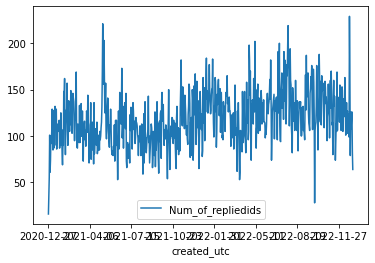

In [ ]:
lines = comment_s.plot.line(y='Num_of_repliedids')

<Axes: xlabel='created_utc'>

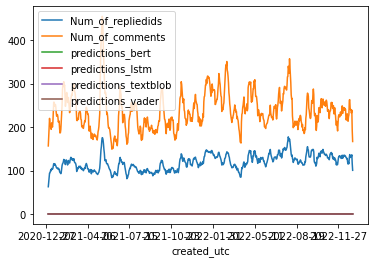

In [ ]:
ma.plot()

<Axes: xlabel='created_utc'>

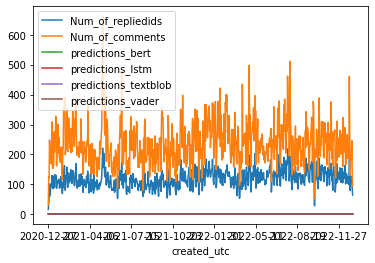

In [ ]:
comment_s.plot()

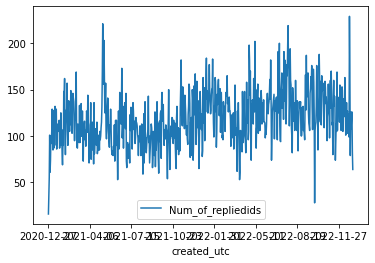

In [ ]:
comment_s.plot(y = 'Num_of_repliedids')
plt.show()

In [ ]:
comment.shape

(173867, 17)

In [ ]:
comment.head()

,created_utc,commentID,link,is_submitter,author,author_flair_richtext,link_id,parent_id,score,body,is_submitier,post_id,predictions_bert,predictions_textblob,predictions_vader,predictions_lstm,body1
0,2021-12-31,hqrvdz6,https://www.reddit.com/r/work/comments/rsrfa3/...,NaN,Additional_Repeat_12,[],t3_rsrfa3,None,2,Even when I work salary I don’t answer calls d...,False,rsrfa3,1,1,1,1,work salary answer call time work life balanc...
1,2021-12-31,hqrupnz,https://www.reddit.com/r/work/comments/rtaumo/...,NaN,X-Bones_21,[],t3_rtaumo,38623883497,3,I second this. When I sorted for UPS I rarely...,False,rtaumo,1,1,0,0,second sort ups rarely interact coworker go...
2,2021-12-31,hqrtx88,https://www.reddit.com/r/work/comments/rtaumo/...,NaN,getfuckedhoayoucunts,[],t3_rtaumo,None,-3,CEO \n\nUsless fucks just sit piss arsing abou...,False,rtaumo,0,0,0,1,ceo \n\n usless fuck sit piss arse listen \n\...
3,2021-12-31,hqrs9pw,https://www.reddit.com/r/work/comments/rtaumo/...,NaN,[deleted],NaN,t3_rtaumo,None,1,Accounting,False,rtaumo,1,1,1,1,account
4,2021-12-31,hqrrz2c,https://www.reddit.com/r/work/comments/rsp1vx/...,NaN,PristineAd9800,[],t3_rsp1vx,None,2,I’d work and see what happens. He didn’t cuz y...,False,rsp1vx,0,1,1,1,work happen cuz maybe thing got heat cuz say...


In [ ]:
event = comment[comment['created_utc']=='2021-06-07']

In [ ]:
event.shape

(215, 17)

In [ ]:
event.head()

,created_utc,commentID,link,is_submitter,author,author_flair_richtext,link_id,parent_id,score,body,is_submitier,post_id,predictions_bert,predictions_textblob,predictions_vader,predictions_lstm,body1
26258,2021-06-07,h0zxpv4,https://www.reddit.com/r/work/comments/nuwcrp/...,NaN,MavenMermaid,[],t3_nuwcrp,37065641374,1,Help a coworker out and put a delayed send on ...,False,nuwcrp,0,0,1,1,help coworker delay send message look like sen...
26259,2021-06-07,h0zxbxa,https://www.reddit.com/r/work/comments/nuwcrp/...,NaN,AnnualPanda,[],t3_nuwcrp,37065578652,1,An entire spiel saying things pertaining to wh...,True,nuwcrp,1,0,0,1,entire spiel say thing pertain abc process...
26260,2021-06-07,h0zvzj0,https://www.reddit.com/r/work/comments/nuwcrp/...,NaN,MavenMermaid,[],t3_nuwcrp,None,1,What were the contents of the message?,False,nuwcrp,0,1,1,1,content message
26261,2021-06-07,h0zuktv,https://www.reddit.com/r/work/comments/nuvmku/...,NaN,http-t,[],t3_nuvmku,37065481614,1,"I appreciate that a lot. Yes, as of now I thin...",True,nuvmku,1,1,1,1,appreciate lot yes think good summer work de...
26262,2021-06-07,h0ztwni,https://www.reddit.com/r/work/comments/nuvmku/...,NaN,PetmyCAD,[],t3_nuvmku,None,1,You work on weekends too?! I mean if your fina...,False,nuvmku,1,0,1,1,work weekend mean financial situation requir...


In [ ]:

count = event.groupby('post_id').size().sort_values(ascending=False)
print(count)

post_id
nui53c    35
nu9cqg    18
nu1l9d    11
nuiw46    10
nukjvh     8
nujxgj     8
nu7siv     8
nuhsrn     7
nucso8     6
ntwr3s     6
nu9l0z     5
nufegi     4
nuff60     4
nua1rx     4
nurg70     4
nfrpcf     4
nu9cm8     4
nuj7wc     3
nukka9     3
nupk1j     3
nurpg9     3
nuu404     3
nuwcrp     3
nu488x     3
nsc3qw     3
nu6yx0     2
nugypy     2
nuvmku     2
numy7d     2
nuk2xb     2
nu5i6a     2
nuicfg     2
ntok8k     2
ntiex7     2
ntyic0     2
n5py1j     2
nty8zm     2
ntosad     1
nun0id     1
n9x9k7     1
nuti1c     1
nustip     1
nlidza     1
nr29z3     1
nuqqcn     1
nuq0u4     1
nrl9wi     1
nu9zdr     1
nulbzv     1
nua08g     1
nt1c23     1
nt94r9     1
ntyaq2     1
nuj3xp     1
ntlkqd     1
nufaab     1
ntmzxb     1
mai5hh     1
dtype: int64


In [ ]:
#t= event[(event['post_id'] == 'nui53c') & (event['is_submitier'] == True)]['body']
t= event[(event['post_id'] == 'nu9cqg')]['body']

In [ ]:
t.to_excel('/content/drive/MyDrive/nu9cqg.xlsx')

In [ ]:
event['body'] = event['body'].apply(lambda x: " ".join([y.lemma_ for y in nlp(x) if not y.is_stop]))

<ipython-input-159-42f42115b181>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  event['body'] = event['body'].apply(lambda x: " ".join([y.lemma_ for y in nlp(x) if not y.is_stop]))


In [ ]:
max_features = 3000
maxlen = 80  # cut texts after this number of words (among top max_features most common words)
batch_size = 32
tokenizer1 = Tokenizer(num_words=max_features, split=' ')
tokenizer1.fit_on_texts(event['body'].values)

In [ ]:
word_counts_0607 = tokenizer1.word_counts
df_0607 = pd.DataFrame(word_counts_0607, index=[0])
df_0607t = df_0607.T
df_0607t.to_csv('/content/drive/MyDrive/word_0607.csv', index=True)

In [ ]:

count_all = comment.groupby('post_id').size().to_frame(name='Count').reset_index()

In [ ]:
count_all = count_all.sort_values(by='Count', ascending=False)

In [ ]:
count_all.head(10)

,post_id,Count
3887,n6265c,251
15424,ubjga8,246
9745,qs9z2r,243
5422,o5f5i8,242
18698,w9l63a,232
14955,tzpj2c,219
18789,wbi82x,210
3931,n6vx0g,204
2880,mie7mc,185
18912,weg1dl,184


In [ ]:
count_all.columns

Index(['post_id', 'Count'], dtype='object')

In [ ]:
merged_df = pd.merge(comment, count_all, on='post_id')

In [ ]:
merged_df.head()

,created_utc,commentID,link,is_submitter,author,author_flair_richtext,link_id,parent_id,score,body,is_submitier,post_id,predictions_bert,predictions_textblob,predictions_vader,predictions_lstm,body1,Count,top10
0,2021-12-31,hqrvdz6,https://www.reddit.com/r/work/comments/rsrfa3/...,NaN,Additional_Repeat_12,[],t3_rsrfa3,None,2,Even when I work salary I don’t answer calls d...,False,rsrfa3,1,1,1,1,work salary answer call time work life balanc...,38,0
1,2021-12-31,hqrhxzc,https://www.reddit.com/r/work/comments/rsrfa3/...,NaN,Vidata,[],t3_rsrfa3,None,3,Are they paying you for it? If not don’t answe...,False,rsrfa3,1,1,1,0,pay answer tell reply pay feel like expect r...,38,0
2,2021-12-31,hqqvjbq,https://www.reddit.com/r/work/comments/rsrfa3/...,NaN,twewff4ever,[],t3_rsrfa3,None,2,I’m salary and I refuse to check email or resp...,False,rsrfa3,1,1,0,1,salary refuse check email respond outside work...,38,0
3,2021-12-31,hqqsm5h,https://www.reddit.com/r/work/comments/rsrfa3/...,NaN,Junior-Bake5741,[],t3_rsrfa3,None,1,Yes. This is how it is. And has been for at le...,False,rsrfa3,0,1,1,1,yes 15 year,38,0
4,2021-12-31,hqqnifr,https://www.reddit.com/r/work/comments/rsrfa3/...,NaN,Klobb119,[],t3_rsrfa3,38620151232,2,Someone should've told me this earlier cause I...,False,rsrfa3,0,1,1,1,tell early cause deal year,38,0


In [ ]:
merged_df.shape

(173867, 18)

In [ ]:
merged_df['top10'] = merged_df.apply(lambda x: 1 if x['Count'] >=184 else 0, axis=1)

In [ ]:
top10 = merged_df[merged_df['top10'] == 1]

In [ ]:
top10.shape

(2216, 19)

In [ ]:
top10.head()

,created_utc,commentID,link,is_submitter,author,author_flair_richtext,link_id,parent_id,score,body,is_submitier,post_id,predictions_bert,predictions_textblob,predictions_vader,predictions_lstm,body1,Count,top10
12109,2021-10-20,hhc95p4,https://www.reddit.com/r/work/comments/n6vx0g/...,NaN,BraSS72097,[],t3_n6vx0g,None,1,This is the fakest shit I've ever seen lol.\n\...,False,n6vx0g,1,1,0,1,fake shit see lol \n\n jobboy good website ea...,204,1
12110,2021-05-12,gxvjmxk,https://www.reddit.com/r/work/comments/n6vx0g/...,NaN,[deleted],NaN,t3_n6vx0g,None,1,[removed],False,n6vx0g,0,1,1,1,remove,204,1
12111,2021-05-12,gxvj8au,https://www.reddit.com/r/work/comments/n6vx0g/...,NaN,[deleted],NaN,t3_n6vx0g,None,1,[removed],False,n6vx0g,0,1,1,1,remove,204,1
12112,2021-05-12,gxviot2,https://www.reddit.com/r/work/comments/n6vx0g/...,NaN,[deleted],NaN,t3_n6vx0g,None,1,[removed],False,n6vx0g,0,1,1,1,remove,204,1
12113,2021-05-12,gxviclx,https://www.reddit.com/r/work/comments/n6vx0g/...,NaN,ashikurjaman2580,[],t3_n6vx0g,None,1,Nice project,False,n6vx0g,1,1,1,0,nice project,204,1


In [ ]:
top10.to_csv('/content/drive/MyDrive/top10.csv', index=True)

In [ ]:
test = pd.read_csv('/content/drive/MyDrive/top10.csv')

In [ ]:
max_features = 3000
maxlen = 120  # cut texts after this number of words (among top max_features most common words)
batch_size = 32
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(top10['body1'].values)

In [ ]:
word_counts_top10 = tokenizer.word_counts
df_top10 = pd.DataFrame(word_counts_top10, index=[0])
df_top10t = df_top10.T
df_top10t.to_csv('/content/drive/MyDrive/word_top10.csv', index=True)